## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras
from keras.layers import BatchNormalization

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=True)

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
keras.backend.clear_session() # 把舊的 Graph 清掉
print("Experiment with save_best_only=1")

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt])
    
# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]
    
exp_name_tag = "exp-save_best_only=1" 
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

Experiment with save_best_only=1
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Bat

50000/50000 [==============================] - 2s 45us/step - loss: 0.5743 - accuracy: 0.8314 - val_loss: 1.6512 - val_accuracy: 0.4897
Epoch 47/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.5583 - accuracy: 0.8368 - val_loss: 1.6610 - val_accuracy: 0.4875
Epoch 48/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.5408 - accuracy: 0.8430 - val_loss: 1.6694 - val_accuracy: 0.4905
Epoch 49/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.5243 - accuracy: 0.8499 - val_loss: 1.6642 - val_accuracy: 0.4877
Epoch 50/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.5056 - accuracy: 0.8592 - val_loss: 1.6840 - val_accuracy: 0.4895


In [8]:
# Load back
model = keras.models.load_model("./tmp.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 95us/step


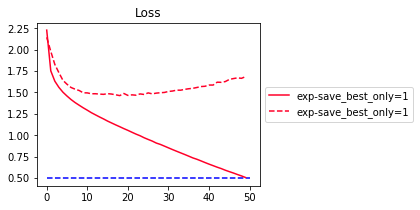

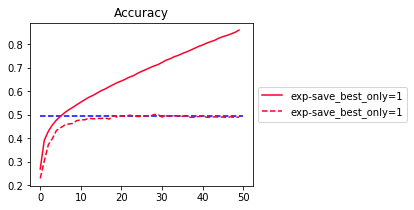

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(4,3))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='b', linestyles='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(4,3))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='b', linestyles='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# 1.save_best_only=False

In [12]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
model_ckpt = ModelCheckpoint(filepath="./tmp2.h5", 
                             monitor="val_loss", 
                             save_best_only=False)

"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
keras.backend.clear_session() # 把舊的 Graph 清掉
print("Experiment with save_best_only=0")

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt])
    
# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]
    
exp_name_tag = "exp-save_best_only=0"
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

Experiment with save_best_only=0
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Bat

50000/50000 [==============================] - 2s 46us/step - loss: 0.5496 - accuracy: 0.8385 - val_loss: 1.6423 - val_accuracy: 0.4898
Epoch 47/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.5343 - accuracy: 0.8467 - val_loss: 1.6787 - val_accuracy: 0.4821
Epoch 48/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.5179 - accuracy: 0.8530 - val_loss: 1.6915 - val_accuracy: 0.4873
Epoch 49/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.4994 - accuracy: 0.8596 - val_loss: 1.6876 - val_accuracy: 0.4783
Epoch 50/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.4820 - accuracy: 0.8653 - val_loss: 1.7064 - val_accuracy: 0.4872


In [13]:
# Load back
model = keras.models.load_model("./tmp2.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 96us/step


In [14]:
model = keras.models.load_model("./tmp.h5")
loss_loadback1, acc_loadback1 = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 95us/step


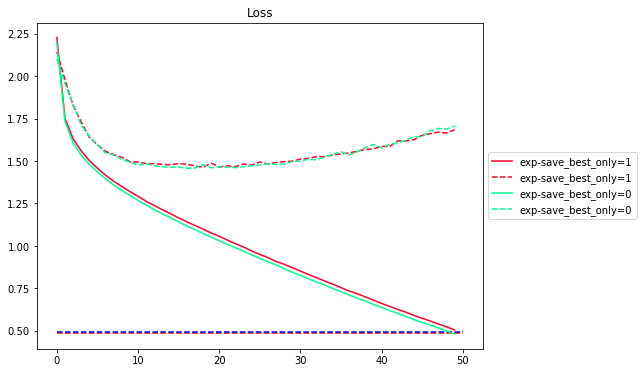

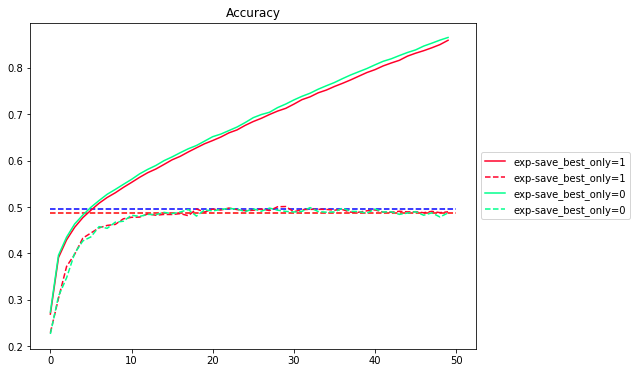

In [16]:
"""Code Here
將結果繪出
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.hlines(y=acc_loadback1, xmin=0, xmax=len(train_loss), colors='b', linestyles='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.hlines(y=acc_loadback1, xmin=0, xmax=len(train_loss), colors='b', linestyles='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# 2.save_weights_only=True

In [17]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="./tmp3.h5", 
                             monitor="val_loss", 
                             save_best_only=True,
                             save_weights_only=True)

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
keras.backend.clear_session() # 把舊的 Graph 清掉
print("Experiment with save_weights_only=True")

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt])
    
# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]
    
exp_name_tag = "exp-save_weights_only=1" 
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

Experiment with save_weights_only=True
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_

50000/50000 [==============================] - 2s 46us/step - loss: 0.5522 - accuracy: 0.8398 - val_loss: 1.6304 - val_accuracy: 0.4878
Epoch 47/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.5345 - accuracy: 0.8455 - val_loss: 1.6379 - val_accuracy: 0.4885
Epoch 48/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.5182 - accuracy: 0.8525 - val_loss: 1.6600 - val_accuracy: 0.4865
Epoch 49/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.5030 - accuracy: 0.8588 - val_loss: 1.6853 - val_accuracy: 0.4831
Epoch 50/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.4864 - accuracy: 0.8655 - val_loss: 1.6839 - val_accuracy: 0.4854


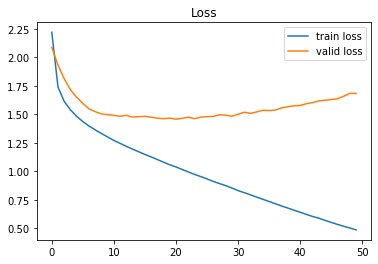

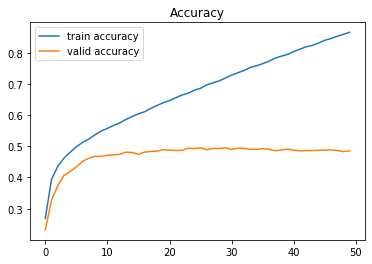

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

In [29]:
model.predict(x_train[0:2])

array([[1.15683209e-02, 6.86106132e-03, 1.06722564e-01, 1.28901243e-01,
        1.08191244e-01, 1.35669950e-02, 5.81427574e-01, 4.23509590e-02,
        2.12169864e-04, 1.97846879e-04],
       [1.73292998e-02, 8.64365473e-02, 1.30235951e-03, 5.31818159e-03,
        9.61610232e-04, 3.20535228e-02, 7.53443863e-04, 1.35433108e-01,
        5.97314648e-02, 6.60680413e-01]], dtype=float32)

In [1]:
import keras
from keras.layers import BatchNormalization

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [8]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
model = build_mlp(input_shape=x_train.shape[1:])
model.load_weights("./tmp3.h5")
print("test after load: ", model.predict(x_train[0:2]))

test after load:  [[0.00790455 0.00553803 0.05294235 0.49086645 0.02886424 0.04826418
  0.27953637 0.08180337 0.00115743 0.00312298]
 [0.01562007 0.67058986 0.00467257 0.00477064 0.00369461 0.01326833
  0.00128474 0.01964076 0.15647574 0.10998262]]
